In [1]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
#Генерация данных
mean1 = [-1, 2]
mean2 = [1, -1]
mean3 = [4, -4]
mean4 = [-4, 4]
cov = [[1.0,0.8], [0.8, 1.0]]
X1 = np.random.multivariate_normal(mean1, cov, 50)
X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
y1 = np.ones(len(X1))
X2 = np.random.multivariate_normal(mean2, cov, 50)
X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
y2 = np.ones(len(X2)) * -1

In [3]:
# Разделение на обучающую и тестовую последовательность
X1_train = X1[:80]
y1_train = y1[:80]
X2_train = X2[:80]
y2_train = y2[:80]
X_train = np.vstack((X1_train, X2_train))
y_train = np.hstack((y1_train, y2_train))

X1_test = X1[80:]
y1_test = y1[80:]
X2_test = X2[80:]
y2_test = y2[80:]
X_test = np.vstack((X1_test, X2_test))
y_test = np.hstack((y1_test, y2_test))

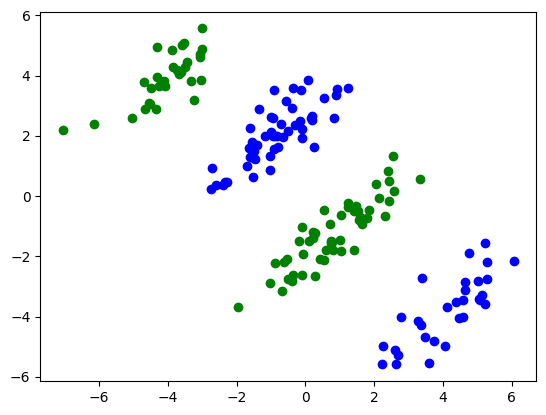

In [ ]:
plt.plot(X1_train[:,0], X1_train[:,1], "bo")
plt.plot(X2_train[:,0], X2_train[:,1], "go")

SVM классификатор

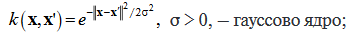

In [ ]:
def gaussian_kernel(x, y, sigma=5):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

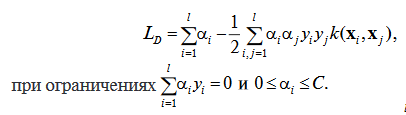

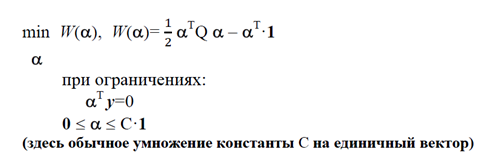

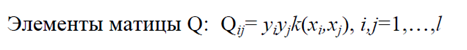

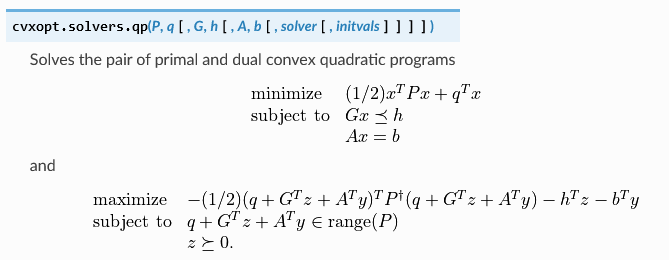

In [ ]:
class SVM(object):

    def __init__(self, kernel= linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Создание матрицы скалярного произведения векторов с учетом ядерной функции
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Ставим задачу квадратичного программирования
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Решаем задачу квадратичного программирования
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Коэф Лагранжа
        al = np.ravel(solution['x'])

        # Округление значения коэф лагранжа
        a = []
        for i in al:
          r = round (i,1)
          a.append(r)
        a = np.array(a)


        # Нахождение опорных векторов
        sv = a > 1e-3
        bsv = a==self.C
        ind = np.arange(len(a))[sv]
        indb = np.arange (len(a))[bsv]
        self.a = a[sv]
        self.sv_x = X[sv]
        self.sv_y = y[sv]

        self.bsv_x = X[bsv]
        self.bsv_y = y[bsv]
        print("%d SV out of %d points" % (len(self.a), n_samples))
        print("%d USV out of %d points" % (len(self.a) - len(self.bsv_x), n_samples))
        print("%d BSV out of %d points" % (len(self.bsv_x), n_samples))


        # Коэффициент b
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Расчет коэф w для линейного классификатора
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv_x[n]
        else:
            self.w = None

    #Создание функции классификатора (если линейный, то есть w)
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv_x):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [ ]:
clf = SVM(gaussian_kernel,C=10000)
clf.fit(X_train,y_train)

     pcost       dcost       gap    pres   dres
 0:  8.0775e+08 -5.0524e+09  6e+09  5e-11  2e-11
 1:  2.6340e+08 -5.2201e+08  8e+08  3e-11  3e-11
 2:  4.9699e+07 -7.5523e+07  1e+08  9e-13  1e-11
 3:  7.6265e+06 -1.0686e+07  2e+07  5e-12  7e-12
 4:  1.1019e+06 -1.2713e+06  2e+06  5e-12  3e-12
 5:  1.5625e+05 -1.8240e+05  3e+05  2e-12  1e-12
 6:  2.1507e+04 -2.6767e+04  5e+04  7e-14  4e-13
 7:  2.6900e+03 -4.1894e+03  7e+03  3e-14  2e-13
 8:  1.7769e+02 -7.7341e+02  1e+03  3e-14  7e-14
 9: -1.0202e+02 -3.1290e+02  2e+02  8e-14  4e-14
10: -1.6047e+02 -3.5721e+02  2e+02  3e-14  4e-14
11: -2.4023e+02 -2.8308e+02  4e+01  5e-14  5e-14
12: -2.5833e+02 -2.7324e+02  1e+01  9e-15  5e-14
13: -2.6424e+02 -2.7008e+02  6e+00  1e-13  6e-14
14: -2.6736e+02 -2.6769e+02  3e-01  1e-13  7e-14
15: -2.6755e+02 -2.6755e+02  4e-03  9e-14  7e-14
16: -2.6755e+02 -2.6755e+02  4e-05  8e-15  7e-14
Optimal solution found.
8 SV out of 160 points
8 USV out of 160 points
0 BSV out of 160 points


In [ ]:
print ("Коэф Лагранжа:", clf.a)
print ("Опорные векторы:", clf.sv_x)
print ("Коэф b:",clf.b)

Коэф Лагранжа: [ 43.9  38.6 129.4  55.6   1.5 153.8  46.7  65.5]
Опорные векторы: [[-1.02647766  0.88247141]
 [-2.75597666  0.21964634]
 [ 0.2403735   1.62603987]
 [ 3.39916407 -2.72520345]
 [-1.95681114 -3.68536124]
 [ 0.54018779 -0.44700936]
 [ 2.53957326  1.31496893]
 [-3.2289688   3.1970859 ]]
Коэф b: -0.03715813241178623


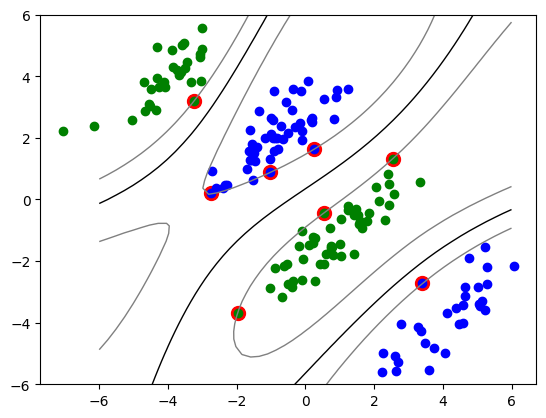

In [ ]:
#Построение графика
plt.plot(X1_train[:,0], X1_train[:,1], "bo")
plt.plot(X2_train[:,0], X2_train[:,1], "go")
plt.scatter(clf.sv_x[:,0], clf.sv_x[:,1], s=100, c="r")
plt.scatter(clf.bsv_x[:,0], clf.bsv_x[:,1], s=100, c="y")


X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
Z = clf.project(X).reshape(X1.shape)
plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

plt.axis("tight")
plt.show()

Точность классификации

In [ ]:
correct = np.sum(clf.predict(X_test) == y_test)
print('Точность классификации:', accuracy_score(y_test, clf.predict(X_test)))
print("%d векторов из %d предсазаны верно" % (correct, len(clf.predict(X_test))))

Точность классификации: 1.0
40 векторов из 40 предсазаны верно


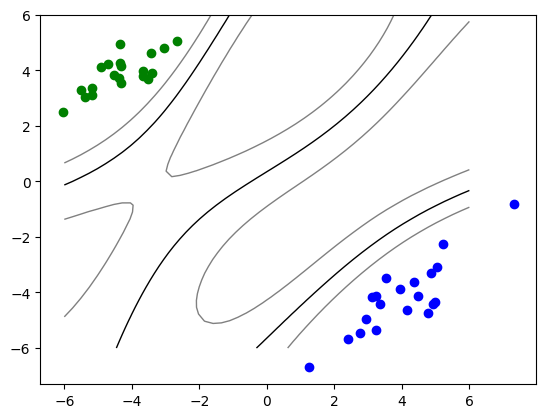

In [ ]:
#Построение графика
plt.plot(X1_test[:,0], X1_test[:,1], "bo")
plt.plot(X2_test[:,0], X2_test[:,1], "go")



X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
Z = clf.project(X).reshape(X1.shape)
plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

plt.axis("tight")
plt.show()